# Improving CNN Generalization with Progressive Resizing and Randomized Progressive Deblurring

By: Dylan Khor


#1. Installing and Importing all necessary libraries

Installing torchvision:

In [ ]:
!pip3 install torchvision

Import necessary libraries and setting matplotlib parameters:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
import torch.optim as optim
from prettytable import PrettyTable, ALL
from timeit import default_timer as timer


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Use GPU if available else use CPU:

In [ ]:
# Define device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 2. Function for turning dataset into dataloaders

In [ ]:
# Function to get training, validation, and test datasets with the specified batch size from a desired dataset
def get_dataset_info(transform, batch_size, dataset_name):
    """
    Loads any image dataset available in torchvision.datasets, applies transformations, and splits it into training, validation, and test sets.

    Args:
    - transform: PyTorch transformation to apply to the data.
    - batch_size: number of examples processed per step
    - dataset_name: name of dataset to be used as a function for getting the dataset from Pytorch dataset module
                    e.g. "MNIST" or "CIFAR10"

    Returns:
    - trainloader: DataLoader for the training set.
    - valloader: DataLoader for the validation set.
    - testloader: DataLoader for the test set.
    - classes: the class names in the dataset
    - num_channels: the number of channels of images in the dataset, e.g., CIFAR-10 has 3 (RGB), MNIST has 1 (gray-scale)
    - side_length: the length of image width or height, CIFAR-10 has 32 (32 x 32 x 3) while MNIST has 28 (28 x 28 x 3)
    """
    # Load desired dataset
    func = getattr(torchvision.datasets, dataset_name)
    trainset = func(root='./data', train=True, download=True, transform=transform)
    testset = func(root='./data', train=False, download=True, transform=transform)

    # Get image channels and dimensions
    num_channels = trainset[0][0].size()[0]
    side_length = trainset[0][0].size()[1]

    # Map classes
    classes = list(trainset.class_to_idx.keys())

    # # Split the training dataset into training and validation
    trainset, valset = torch.utils.data.random_split(trainset, [0.8, 0.2]) # 80% of training set will be training set, and 20% of training set will be validation set

    # Create data loaders for training, validation, and test with the specified batch size
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader, testloader, classes, num_channels, side_length

# 3. Explore how Gaussian blur affects CIFAR-10 images with different σ (blurring intensity) values

In [ ]:
resize = 32 # For learning purposes

cifar_10_transform = transforms.Compose(
    [transforms.ToTensor(), # convert Python Image Library (PIL) format to PyTorch tensors
     transforms.Resize(resize), # Resize the images to desired dimensions
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize the data by specifying a mean and standard deviation for each of the three channels, this will convert the
                                                              # values from range [0,1] to [-1,1]

# Load CIFAR-10 dataset into trainloader, validation loader, and test loader, using the transformation above and a batch size of 4
cifar_10_trainloader, cifar_10_valloader, cifar_10_testloader, cifar_10_classes, _, _ = get_dataset_info(cifar_10_transform, 4, "CIFAR10")

100%|██████████| 170498071/170498071 [00:03<00:00, 50047249.31it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print("CIFAR-10 classes: ", cifar_10_classes)
print(f"Training set has {len(cifar_10_trainloader.dataset)} images")
print(f"Validation set has {len(cifar_10_valloader.dataset)} images")
print(f"Testing set has {len(cifar_10_testloader.dataset)} images")

CIFAR-10 classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training set has 40000 images
Validation set has 10000 images
Testing set has 10000 images


Using the trainloader we will now get a random batch of 4 training images and plot them to see what CIFAR-10 images look like with the effect of Gaussian Blurring at different strength of blurring σ.

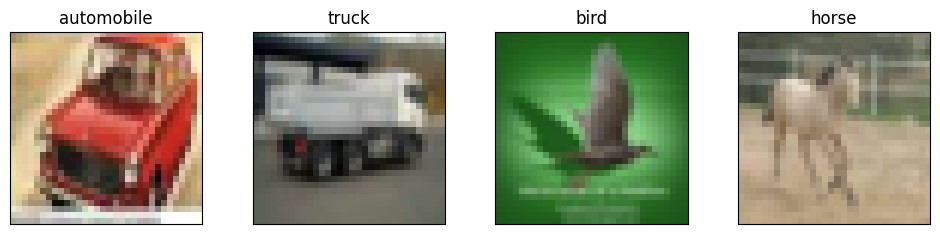

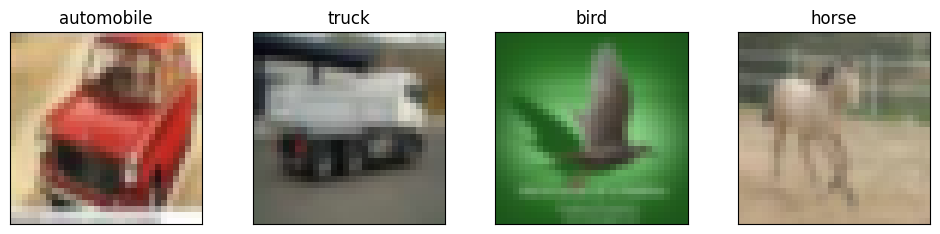

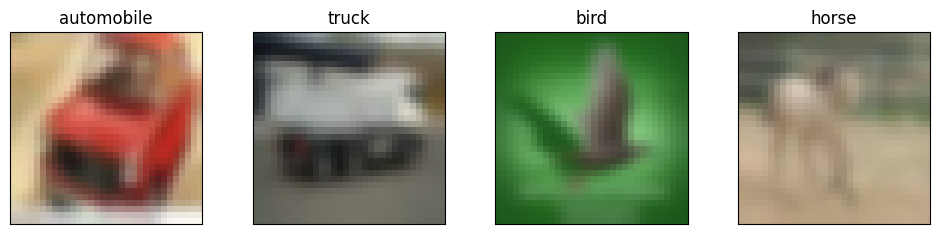

In [ ]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

# Test the effect of GaussianBlur on one 4-batch images.
data_iter = iter(cifar_10_trainloader)
images, labels = next(data_iter)

# Show the original CIFAR-10 images
fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(cifar_10_classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

img1 = transforms.GaussianBlur(5, sigma=0.5)(images)
img2 = transforms.GaussianBlur(5, sigma=1.0)(images)

# Show the CIFAR-10 images with blur intensity of 0.5
fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(img1):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(cifar_10_classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

# Show the CIFAR-10 images with blur intensity of 1.0
fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(img2):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(cifar_10_classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])


As we can see here, as blurring intensity σ increases, the images get more and more distorted. In a sense, blurring achieves the same objective as resizing the images to a smaller dimension, which is to lower image resolution.

# 4 - Setting up a Scalable Convolutional Network

The network used has the following structure,

In [ ]:
from prettytable import PrettyTable, ALL

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Layer", "Type", "Filters", "Filter Size", "Filter Stride", "Filter Padding"])
myTable.hrules=ALL
myTable.add_row(["1", "Convolutional", "16", "3 x 3", "1", "1"])
myTable.add_row(["2", "MaxPool", "-", "2 x 2", "2", "-"])
myTable.add_row(["3", "Convolutional", "32", "3 x 3", "1", "1"])
myTable.add_row(["4", "Convolutional", "16", "1 x 1", "1", "0"])
myTable.add_row(["5", "Convolutional", "32", "3 x 3", "1", "1"])
myTable.add_row(["6", "MaxPool", "-", "2 x 2", "2", "-"])
myTable.add_row(["7", "Convolutional", "64", "3 x 3", "1", "1"])
myTable.add_row(["8", "Convolutional", "32", "1 x 1", "1", "0"])
myTable.add_row(["9", "Convolutional", "64", "3 x 3", "1", "1"])
myTable.add_row(["10", "Convolutional", "10", "1 x 1", "1", "0"])
myTable.add_row(["11", "Dropout", "-", "-", "-", "-"])
myTable.add_row(["12", "AvgPool", "-", "Global", "Global", "-"])
myTable.add_row(["13", "Softmax", "-", "-", "-", "-"])

print(myTable)

+-------+---------------+---------+-------------+---------------+----------------+
| Layer |      Type     | Filters | Filter Size | Filter Stride | Filter Padding |
+-------+---------------+---------+-------------+---------------+----------------+
|   1   | Convolutional |    16   |    3 x 3    |       1       |       1        |
+-------+---------------+---------+-------------+---------------+----------------+
|   2   |    MaxPool    |    -    |    2 x 2    |       2       |       -        |
+-------+---------------+---------+-------------+---------------+----------------+
|   3   | Convolutional |    32   |    3 x 3    |       1       |       1        |
+-------+---------------+---------+-------------+---------------+----------------+
|   4   | Convolutional |    16   |    1 x 1    |       1       |       0        |
+-------+---------------+---------+-------------+---------------+----------------+
|   5   | Convolutional |    32   |    3 x 3    |       1       |       1        |
+---

In [ ]:
# Network to be used for my experiment
class ProgressiveNet(nn.Module):
    def __init__(self, input_channel, num_classes):
        super(ProgressiveNet, self).__init__()
        self.classes = num_classes
        # define network
        self.network = nn.Sequential(
            nn.Conv2d(input_channel, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 16, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 32, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, self.classes, 1),
        )

    def forward(self, x, dropout_rate=None):
      # Define the forward Path of the model here
        size = x.shape[2] # Or x.shape[3] since width and height of CIFAR-10 are the same
        x = self.network(x)
        # Apply dropout if there is a specified dropout rate
        if dropout_rate:
            x = nn.Dropout(dropout_rate)(x)
        x = nn.AvgPool2d(int(size/4))(x) # feature map has size of size/4 due to the two max-pooling layers in the network
        x = x.view(-1, self.classes)
        return x

# 5. Define functions for training on entire training set, validating on entire validation set, and testing on entire testing set






In [ ]:
# Function to train the neural network using training set
def train_model(model, trainloader, optimizer, criterion, device, resize=None, blur=None, dropout_rate=None):
    """
    Trains the neural network on the training dataset.

    Args:
    - model: PyTorch neural network model.
    - trainloader: DataLoader for the training set.
    - optimizer: PyTorch optimizer.
    - criterion: Loss function.
    - device: Device to run the training on (CPU or GPU).
    - resize: the desired image size to be resized to.
    - blur: the desired blurring intensity to be used to blur the image batches
    - dropout_rate: the dropout rate to be applied on the dropout layer of the network during forward pass

    Returns:
    - train_loss: Average training loss for the epoch.
    - train_accuracy: Training accuracy for the epoch.
    - total_time: the total time (in seconds) it takes to train on the whole training set
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    start = timer() # Calculate how much time it takes to train on this epoch in seconds
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        rand = random.random()

        if resize:
            # If resize is specified, resize the batch of images to that size
            inputs = transforms.Resize(resize)(inputs)
            if blur and rand <= 0.4:
                # If blur is specified, blurring of the image batches with the specified intensity happens with 40% chance
                inputs = transforms.GaussianBlur(5, sigma=blur)(inputs)

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients to avoid accumulation

        outputs = model(inputs, dropout_rate)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters
        running_loss += loss.item()  # Accumulate the loss

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    end = timer()

    total_time = end - start
    train_accuracy = 100 * correct_train / total_train

    return running_loss / len(trainloader), train_accuracy, total_time

In [ ]:
# Function to validate the neural network using validation set
def validate_model(model, valloader, device):
    """
    Validates the neural network on the validation dataset.

    Args:
    - model: PyTorch neural network model.
    - valloader: DataLoader for the validation set.
    - device: Device to run the validation on (CPU or GPU).

    Returns:
    - val_accuracy: Validation accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            # if resize:
            #     inputs = transforms.Resize(resize)(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    return val_accuracy

In [ ]:
# Function to test the neural network using test set
def test_model(model, testloader, device):
    """
    Tests the trained neural network on the test dataset.

    Args:
    - model: PyTorch neural network model.
    - testloader: DataLoader for the test set.
    - device: Device to run the testing on (CPU or GPU).

    Returns:
    - test_accuracy: Test accuracy.
    - true_labels: True labels of test samples.
    - predicted_labels: Predicted labels by the model.
    """
    model.eval()
    correct_test = 0
    total_test = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            # if resize:
            #     inputs = transforms.Resize(resize)(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test

    return test_accuracy, true_labels, predicted_labels

# 6. Setting up the Experiment

I will be training the model using each approach for 15 epochs.

In [ ]:
epochs = 15

Define a deep learning pipeline for the whole experiment.

In [ ]:
def train_and_test(trainloader, valloader, testloader, class_names, num_channels, side_length, learn_decay=0.9, mode=None):
    """
    Main function to train and test the model based on the given parameters

    Args:
    - trainloader: training set in Dataloader form
    - valloader: validation set in Dataloader form
    - testloader: testing set in Dataloader form
    - class_names: list of classes in the dataset used
    - num_channels: number of channels of images in the dataset used
    - side_length: width or height of the images in the dataset used
    - learn_decay: learning rate decay factor, set to 0.9 as default
    - mode: training approach to be used.
            --> "progressive" for adaptive progressive resizing
            --> "proposed" for my proposed training approach: adaptive progressive resizing with randomized progressive deblurring
            --> Else the normal training approach.

    Returns:
    - train_accuracy_list: the list of training accuracies at each epoch
    - val_accuracy_list: the list of validation accuracies at each epoch
    - test_accuracy_list: the list of test accuracies at each epoch
    - training_loss_list: the list of training losses at each epoch
    - total_time: the total time needed to finish training over all epochs
    """

    ##################### Define run parameters #########################################
    # Initialize the model
    model = ProgressiveNet(num_channels, len(class_names)).to(device)

    # Define SGD optimizer with 0.01 learning rate and 0.9 momentum, with 0.001 weight decay rate
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9)

    # Define learning rate scheduler to decay learning rate by a factor of 1/learn_decay every 2 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=learn_decay)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    size = None # No resizing needed for normal training procedure

    dropout = 0.4 # Fixed regularization for models using normal training procedure

    blur = None # No blurring needed for normal training procedure

    # In progressive resizing, we will need to downsize our images first then progressively resize it back to the original image size during training
    if mode == "progressive" or mode == "proposed":
        size = side_length - 8 # hardcoded this since I am only training on CIFAR10 for 15 epochs (increase size by 2 every 2 epochs until original size is reached)
        dropout = 0.2 # Start with weak regularization and slowly progress towards dropout rate of 0.4 as image gets larger

    # In my proposed training approach, blurring is introduced
    if mode == "proposed":
        blur = 2.0 # Set blurring intensity to 2 at start and progressively reduce it down to 0 as image size gets larger

    # Lists to store training, validation, and testing accuracy as well as the training losses at each epoch
    train_accuracy_list = []
    val_accuracy_list = []
    test_accuracy_list = []
    training_loss_list = []

    # Set number of epochs to train model for (in my case: 15)
    num_epochs = epochs

    total_time = 0

    # Train the model for multiple epochs
    for epoch in range(num_epochs):
        train_loss, train_accuracy, time_taken = train_model(model, trainloader, optimizer, criterion, device, resize=size, blur=blur, dropout_rate=dropout)
        val_accuracy = validate_model(model, valloader, device)
        test_accuracy, _, _ = test_model(model, testloader, device)

        # Append accuracy and loss values to lists for later plotting
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        test_accuracy_list.append(test_accuracy)
        training_loss_list.append(train_loss)

        print(f"Epoch {epoch + 1}, Learning rate: {optimizer.param_groups[0]['lr']:.3f}, Loss: {train_loss:.2f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, time taken: {time_taken:.2f}s")
        total_time += time_taken

        # If we are not using the normal training algorithm...
        if (epoch + 1) % 2 == 0 and mode:
            if mode == "progressive" or mode == "proposed":
                # Increase size of images to be trained on as well as increasing the power of regularization
                size += 2
                dropout += 0.05
                size = min(size, 32) # size capped at original CIFAR-10 image size, which is 32
                dropout = min(dropout, 0.4) # dropout rate capped at 0.4 because that's the fixed value for the normal training procedure (for fairness)

            if mode == "proposed":
                # Decrease blurring intensity progressively until 0 as image gets resized progressively back to its original resolution
                blur -= 0.5
                blur = max(blur, 0)

        lr_scheduler.step() # Update scheduler to decay learning rate in optimizer

    print(f'Finished Training! Total time taken to train: {total_time:.2f}s')

    # Test the model
    test_accuracy, true_labels, predicted_labels = test_model(model, testloader, device)

    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # Calculate classification report for additional details
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Create confusion matrix for visualization
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot unnormalized confusion matrix
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Unnormalized)')

    # Plot normalized confusion matrix
    normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.subplot(1, 2, 2)
    sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Normalized)')
    plt.tight_layout()
    plt.show()

    # Randomly select 10 samples for testing
    print("")
    print("Randomly Select 10 Samples for Testing:")
    random_indices = random.sample(range(len(testloader.dataset)), 10)
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        image, label = testloader.dataset[idx]
        image = image / 2 + 0.5  # Unnormalize
        np_image = image.numpy()
        plt.imshow(np.transpose(np_image, (1, 2, 0)))
        actual_label = class_names[label]
        predicted_label = class_names[predicted_labels[idx]]
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}', color=("green" if actual_label == predicted_label else "red"))
        plt.axis('off')
    plt.show()

    return train_accuracy_list, val_accuracy_list, test_accuracy_list, training_loss_list, total_time

#7. Training on CIFAR10 with all training algorithms, each 3 times with different dataloaders containing the same dataset (just in different order of batches):

Define some lists to store all the relevant statistics for each training approach for all 3 times:

In [ ]:
norm_stat = []
progressive_stat = []
proposed_stat = []

Define the 3 set of dataloaders (training, validation, testing) to be used, each with a batch size of 128:

In [ ]:
# Select the batch size for training
batch_size = 128

# CIFAR-10 dataset transformation to be applied
cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataloaders = []

num_test = 3

for i in range(num_test):
    # Initialize a CIFAR10 training, validation, and test set to be used for training and testing the model in each different training approaches.
    cifar_trainloader, cifar_valloader, cifar_testloader, cifar_class_names, cifar_num_channels, cifar_side_length = get_dataset_info(cifar_transform, batch_size, "CIFAR10")
    dataloaders.append((cifar_trainloader, cifar_valloader, cifar_testloader, cifar_class_names, cifar_num_channels, cifar_side_length))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Normal training approach:

Epoch 1, Learning rate: 0.010, Loss: 1.64, Training Accuracy: 37.60%, Validation Accuracy: 47.63%, time taken: 12.77s
Epoch 2, Learning rate: 0.010, Loss: 1.25, Training Accuracy: 54.33%, Validation Accuracy: 55.00%, time taken: 12.69s
Epoch 3, Learning rate: 0.009, Loss: 1.07, Training Accuracy: 61.52%, Validation Accuracy: 62.30%, time taken: 12.43s
Epoch 4, Learning rate: 0.009, Loss: 0.98, Training Accuracy: 64.70%, Validation Accuracy: 61.25%, time taken: 12.40s
Epoch 5, Learning rate: 0.008, Loss: 0.91, Training Accuracy: 67.39%, Validation Accuracy: 66.78%, time taken: 12.34s
Epoch 6, Learning rate: 0.008, Loss: 0.86, Training Accuracy: 69.64%, Validation Accuracy: 68.60%, time taken: 12.82s
Epoch 7, Learning rate: 0.007, Loss: 0.80, Training Accuracy: 71.79%, Validation Accuracy: 68.99%, time taken: 12.72s
Epoch 8, Learning rate: 0.007, Loss: 0.77, Training Accuracy: 72.96%, Validation Accuracy: 64.95%, time taken: 12.69s
Epoch 9, Learning rate: 0.007, Loss: 0.73, Training Accu

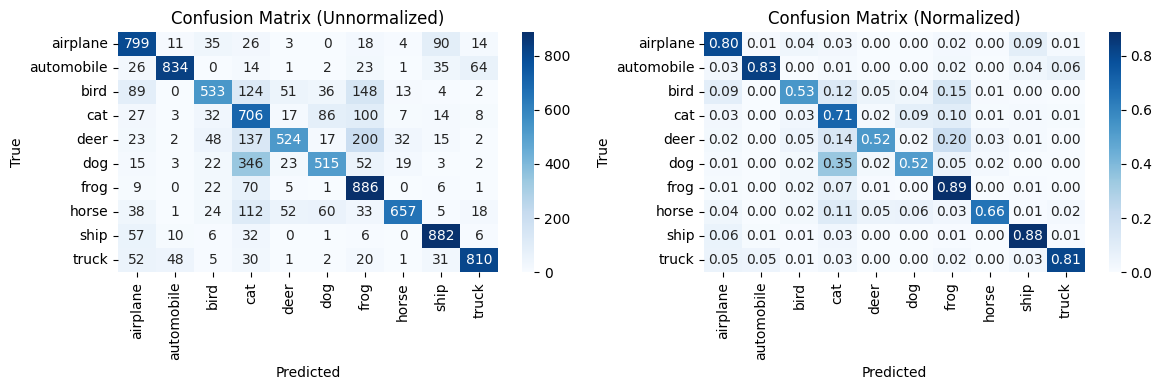


Randomly Select 10 Samples for Testing:


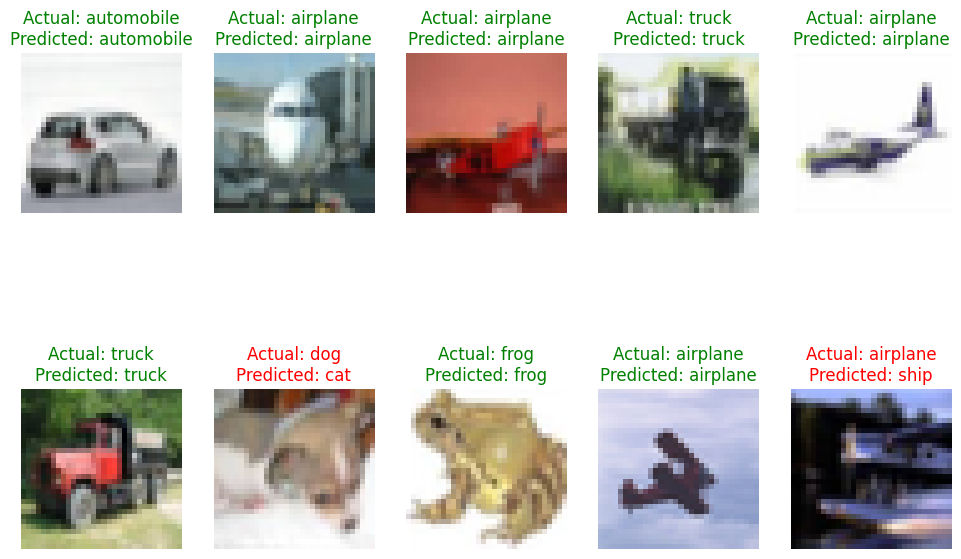

###############################################################################################################################################
Epoch 1, Learning rate: 0.010, Loss: 1.62, Training Accuracy: 39.27%, Validation Accuracy: 40.69%, time taken: 13.12s
Epoch 2, Learning rate: 0.010, Loss: 1.24, Training Accuracy: 54.77%, Validation Accuracy: 53.71%, time taken: 12.69s
Epoch 3, Learning rate: 0.009, Loss: 1.06, Training Accuracy: 61.92%, Validation Accuracy: 55.30%, time taken: 12.63s
Epoch 4, Learning rate: 0.009, Loss: 0.97, Training Accuracy: 65.28%, Validation Accuracy: 63.38%, time taken: 12.79s
Epoch 5, Learning rate: 0.008, Loss: 0.90, Training Accuracy: 68.08%, Validation Accuracy: 65.30%, time taken: 12.54s
Epoch 6, Learning rate: 0.008, Loss: 0.85, Training Accuracy: 70.01%, Validation Accuracy: 59.78%, time taken: 12.74s
Epoch 7, Learning rate: 0.007, Loss: 0.79, Training Accuracy: 72.33%, Validation Accuracy: 60.75%, time taken: 12.18s
Epoch 8, Learning rate: 0.007,

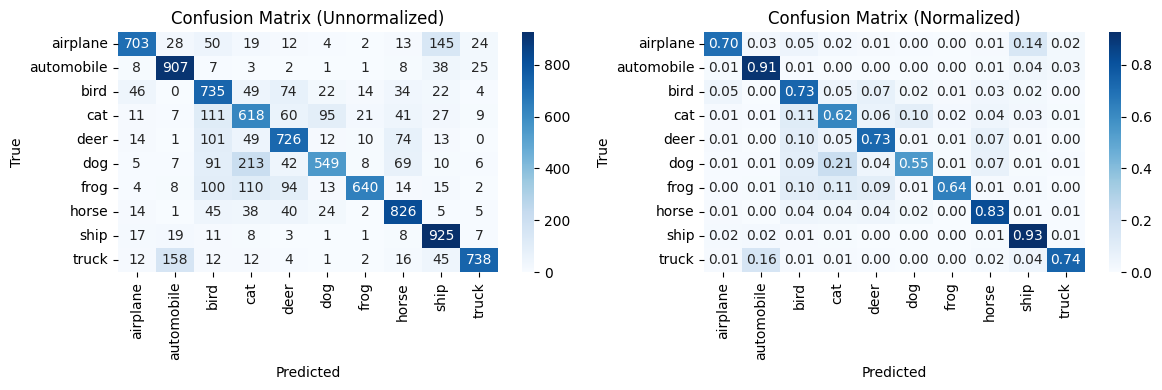


Randomly Select 10 Samples for Testing:


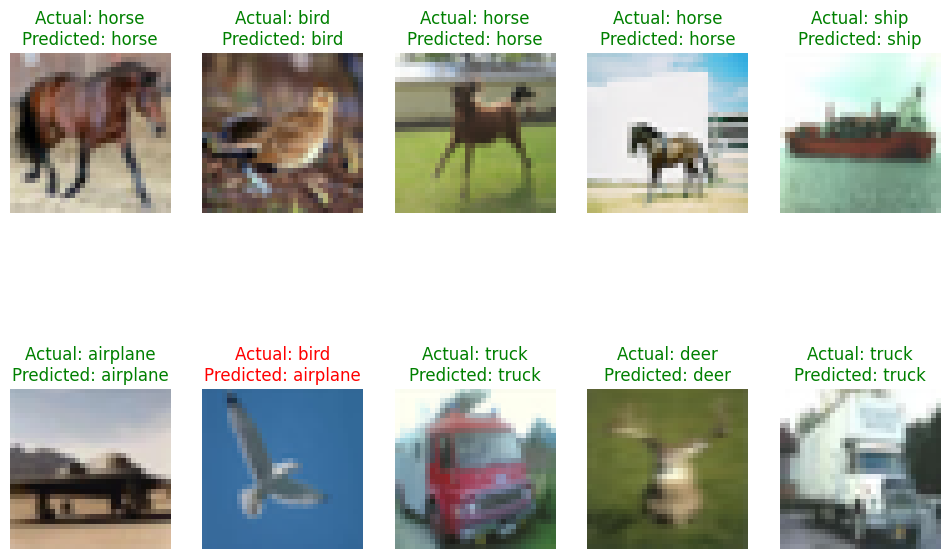

###############################################################################################################################################
Epoch 1, Learning rate: 0.010, Loss: 1.66, Training Accuracy: 37.45%, Validation Accuracy: 44.06%, time taken: 12.80s
Epoch 2, Learning rate: 0.010, Loss: 1.29, Training Accuracy: 52.27%, Validation Accuracy: 56.34%, time taken: 12.48s
Epoch 3, Learning rate: 0.009, Loss: 1.11, Training Accuracy: 59.91%, Validation Accuracy: 60.55%, time taken: 12.09s
Epoch 4, Learning rate: 0.009, Loss: 1.00, Training Accuracy: 64.09%, Validation Accuracy: 57.56%, time taken: 12.82s
Epoch 5, Learning rate: 0.008, Loss: 0.93, Training Accuracy: 66.87%, Validation Accuracy: 59.36%, time taken: 12.88s
Epoch 6, Learning rate: 0.008, Loss: 0.86, Training Accuracy: 69.40%, Validation Accuracy: 61.40%, time taken: 12.76s
Epoch 7, Learning rate: 0.007, Loss: 0.82, Training Accuracy: 71.25%, Validation Accuracy: 70.67%, time taken: 13.02s
Epoch 8, Learning rate: 0.007,

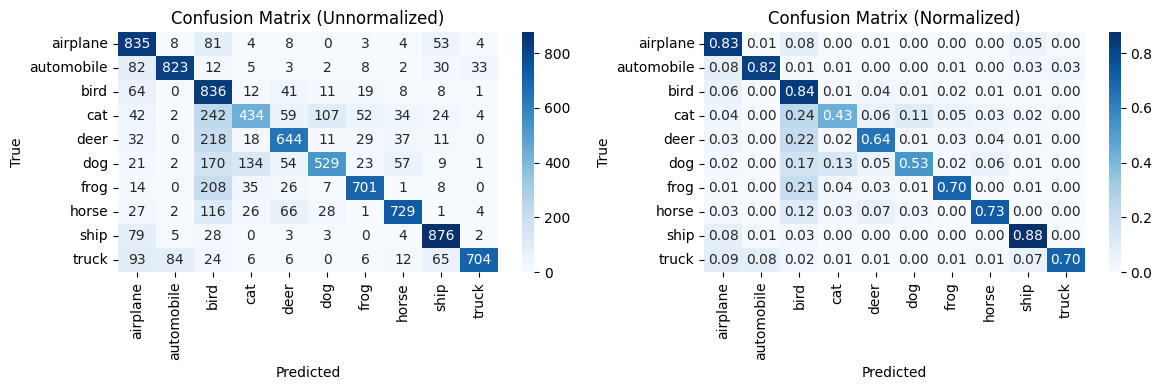


Randomly Select 10 Samples for Testing:


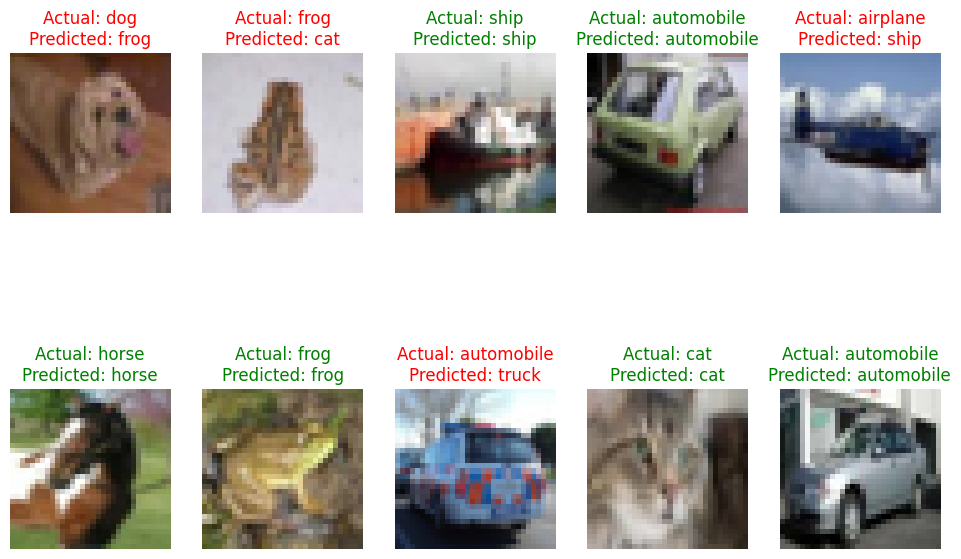

###############################################################################################################################################


In [ ]:
for i in range(num_test):
    norm_train, norm_val, norm_test, norm_loss, norm_time = train_and_test(dataloaders[i][0], dataloaders[i][1], dataloaders[i][2], \
                                                                                       dataloaders[i][3], dataloaders[i][4], dataloaders[i][5])
    norm_stat.append((norm_train, norm_val, norm_test, norm_loss, norm_time))
    print("###############################################################################################################################################")

Adaptive progressive resizing approach:

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Learning rate: 0.010, Loss: 1.66, Training Accuracy: 37.65%, Validation Accuracy: 46.71%, time taken: 13.44s
Epoch 2, Learning rate: 0.010, Loss: 1.29, Training Accuracy: 53.01%, Validation Accuracy: 48.11%, time taken: 12.82s
Epoch 3, Learning rate: 0.009, Loss: 1.12, Training Accuracy: 59.73%, Validation Accuracy: 54.64%, time taken: 12.69s
Epoch 4, Learning rate: 0.009, Loss: 1.01, Training Accuracy: 63.91%, Validation Accuracy: 54.21%, time taken: 13.07s
Epoch 5, Learning rate: 0.008, Loss: 0.96, Training Accuracy: 66.28%, Validation Accuracy: 61.87%, time taken: 13.29s
Epoch 6, Learning rate: 0.008, Loss: 0.89, Training Accuracy: 68.50%, Validation Accuracy: 59.28%, time taken: 13.67s
Epoch 7, Learning rate: 0.007, Loss: 0.86, Training Accuracy: 69.47%, Validation Accuracy: 62.55%, time taken: 13.62s
Epoch 8, Learning rate: 0.007, Loss: 0.80, Training Accuracy: 71.72%, Validation Accuracy: 61.19%, time taken: 13.92s
Epoch 9, Learning rate: 0.007, Loss: 0.77, Training Accu

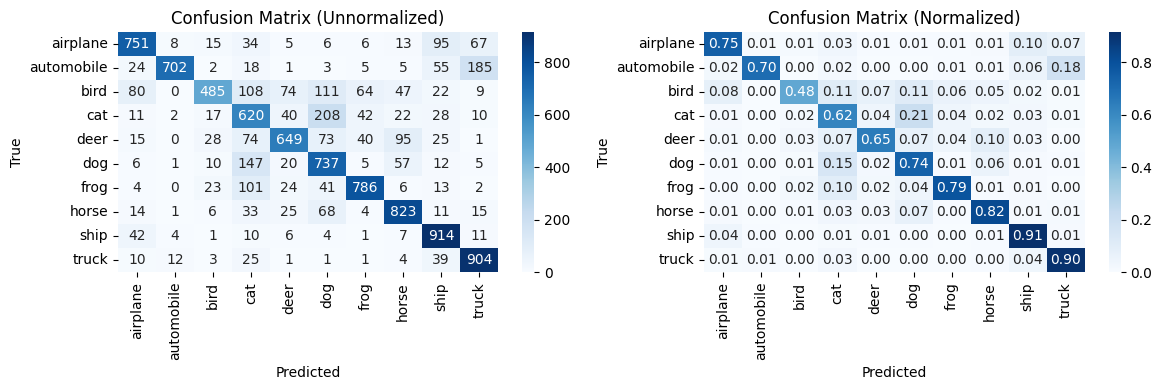


Randomly Select 10 Samples for Testing:


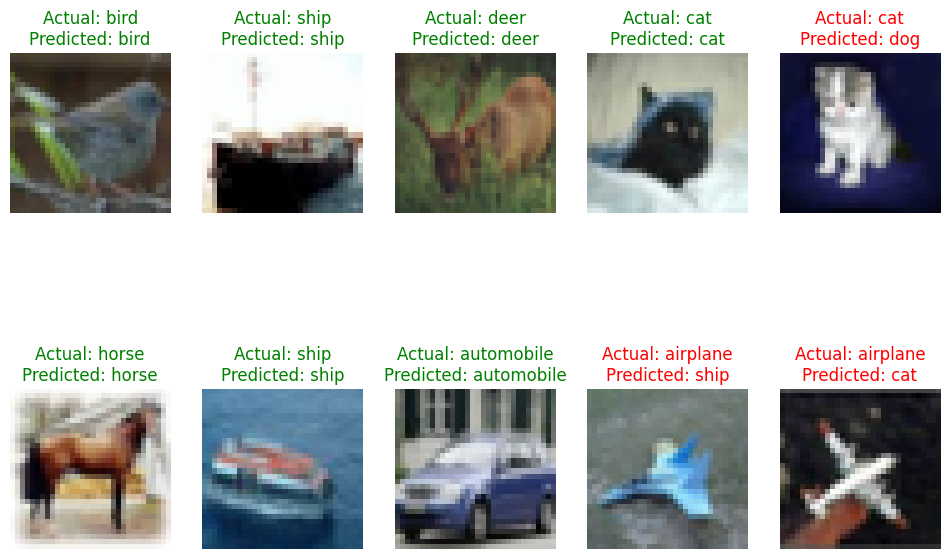

###############################################################################################################################################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Learning rate: 0.010, Loss: 1.64, Training Accuracy: 39.35%, Validation Accuracy: 41.30%, time taken: 14.77s
Epoch 2, Learning rate: 0.010, Loss: 1.27, Training Accuracy: 53.63%, Validation Accuracy: 44.36%, time taken: 13.34s
Epoch 3, Learning rate: 0.009, Loss: 1.12, Training Accuracy: 59.41%, Validation Accuracy: 55.67%, time taken: 13.53s
Epoch 4, Learning rate: 0.009, Loss: 1.01, Training Accuracy: 63.62%, Validation Accuracy: 41.46%, time taken: 13.69s
Epoch 5, Learning rate: 0.008, Loss: 0.95, Training Accuracy: 66.12%, Validation Accuracy: 63.69%, time taken: 13.76s
Epoch 6, Learning rate: 0.008, Loss: 0.89, Training Accuracy: 68.60%, Validation Accuracy: 60.77%, time taken: 13.81s
Epoch 7, Learning rate: 0.007, Loss: 0.85, Training Accuracy: 69.92%, Validation Accuracy: 69.16%, time taken: 13.90s
Epoch 8, Learning rate: 0.007, Loss: 0.80, Training Accuracy: 71.93%, Validation Accuracy: 61.53%, time taken: 14.18s
Epoch 9, Learning rate: 0.007, Loss: 0.76, Training Accu

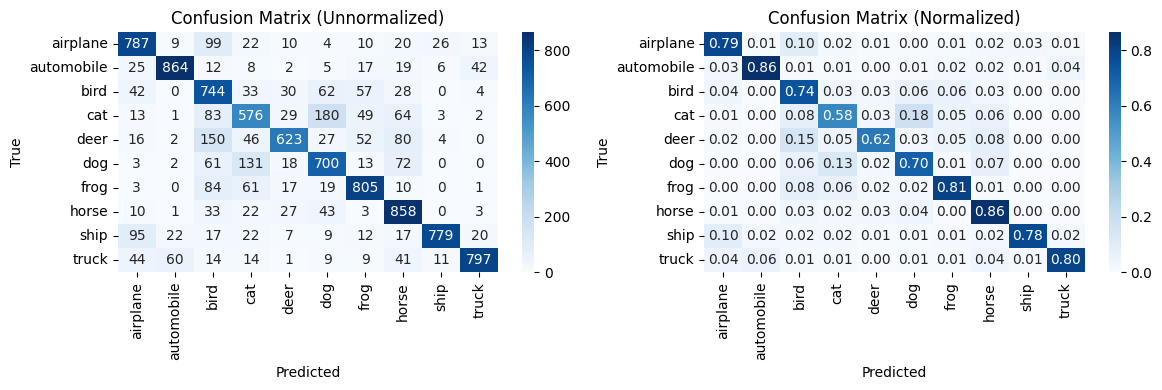


Randomly Select 10 Samples for Testing:


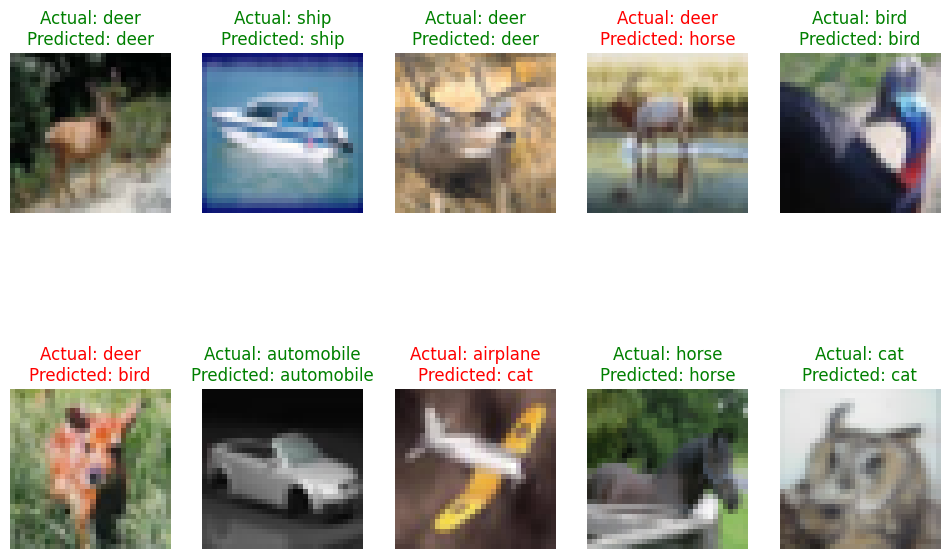

###############################################################################################################################################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Learning rate: 0.010, Loss: 1.64, Training Accuracy: 38.50%, Validation Accuracy: 46.55%, time taken: 13.05s
Epoch 2, Learning rate: 0.010, Loss: 1.26, Training Accuracy: 54.06%, Validation Accuracy: 52.52%, time taken: 13.05s
Epoch 3, Learning rate: 0.009, Loss: 1.11, Training Accuracy: 60.21%, Validation Accuracy: 55.56%, time taken: 13.51s
Epoch 4, Learning rate: 0.009, Loss: 1.02, Training Accuracy: 63.41%, Validation Accuracy: 58.86%, time taken: 13.84s
Epoch 5, Learning rate: 0.008, Loss: 0.95, Training Accuracy: 66.42%, Validation Accuracy: 61.72%, time taken: 13.97s
Epoch 6, Learning rate: 0.008, Loss: 0.88, Training Accuracy: 69.03%, Validation Accuracy: 57.05%, time taken: 13.60s
Epoch 7, Learning rate: 0.007, Loss: 0.85, Training Accuracy: 69.92%, Validation Accuracy: 68.80%, time taken: 13.86s
Epoch 8, Learning rate: 0.007, Loss: 0.80, Training Accuracy: 72.15%, Validation Accuracy: 66.87%, time taken: 13.92s
Epoch 9, Learning rate: 0.007, Loss: 0.76, Training Accu

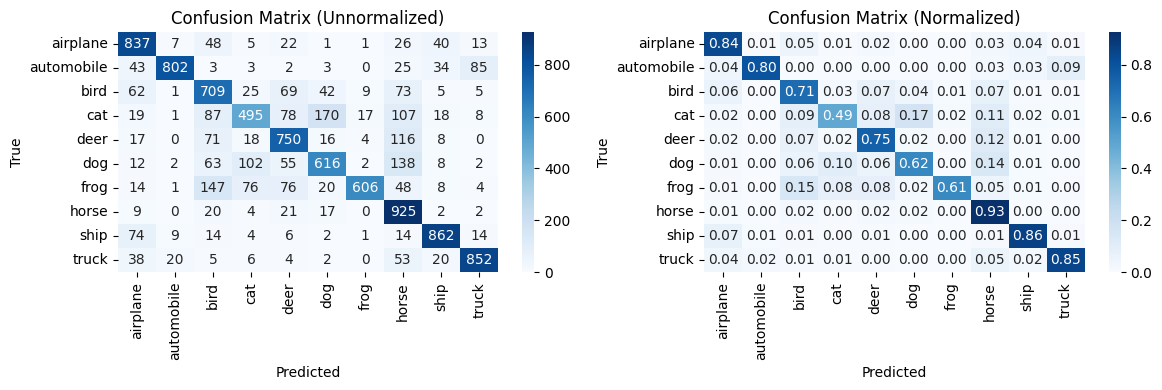


Randomly Select 10 Samples for Testing:


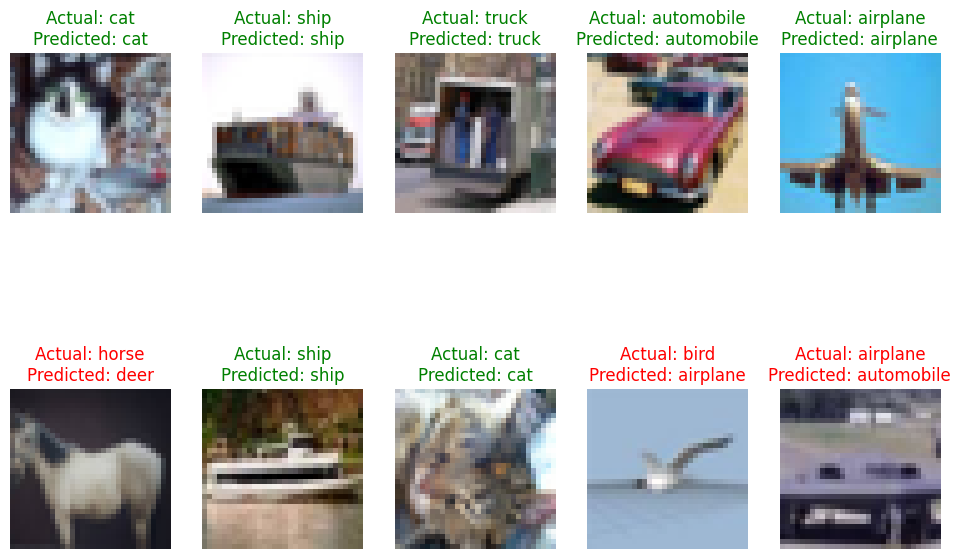

###############################################################################################################################################


In [ ]:
for i in range(num_test):
    progressive_train, progressive_val, progressive_test, progressive_loss, progressive_time = train_and_test(dataloaders[i][0], dataloaders[i][1], dataloaders[i][2], \
                                                                                       dataloaders[i][3], dataloaders[i][4], dataloaders[i][5], mode="progressive")
    progressive_stat.append((progressive_train, progressive_val, progressive_test, progressive_loss, progressive_time))
    print("###############################################################################################################################################")

My proposed approach (adaptive progressive resizing with randomized progressive deblurring):

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Learning rate: 0.010, Loss: 1.71, Training Accuracy: 36.14%, Validation Accuracy: 44.99%, time taken: 13.46s
Epoch 2, Learning rate: 0.010, Loss: 1.41, Training Accuracy: 47.68%, Validation Accuracy: 48.08%, time taken: 13.73s
Epoch 3, Learning rate: 0.009, Loss: 1.26, Training Accuracy: 53.95%, Validation Accuracy: 52.09%, time taken: 13.83s
Epoch 4, Learning rate: 0.009, Loss: 1.17, Training Accuracy: 57.66%, Validation Accuracy: 51.45%, time taken: 13.69s
Epoch 5, Learning rate: 0.008, Loss: 1.07, Training Accuracy: 61.79%, Validation Accuracy: 52.18%, time taken: 14.00s
Epoch 6, Learning rate: 0.008, Loss: 1.01, Training Accuracy: 64.09%, Validation Accuracy: 60.87%, time taken: 13.95s
Epoch 7, Learning rate: 0.007, Loss: 0.92, Training Accuracy: 67.57%, Validation Accuracy: 62.83%, time taken: 14.40s
Epoch 8, Learning rate: 0.007, Loss: 0.87, Training Accuracy: 69.42%, Validation Accuracy: 64.43%, time taken: 14.39s
Epoch 9, Learning rate: 0.007, Loss: 0.82, Training Accu

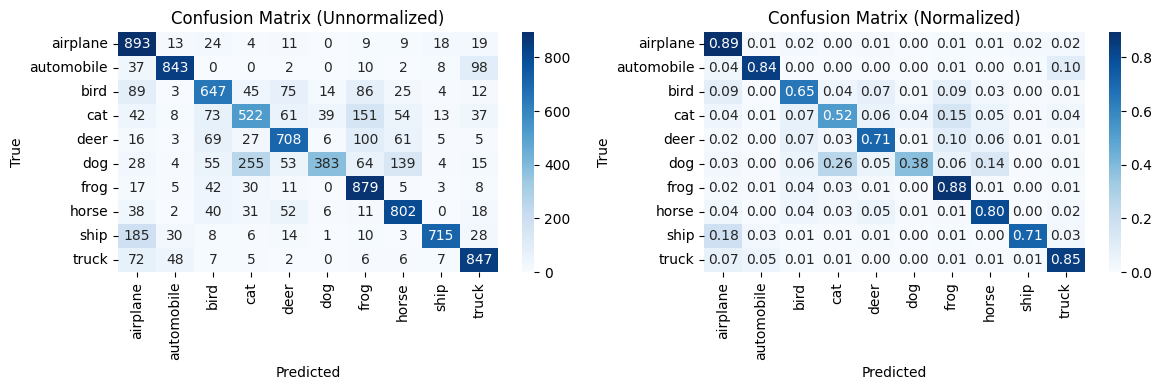


Randomly Select 10 Samples for Testing:


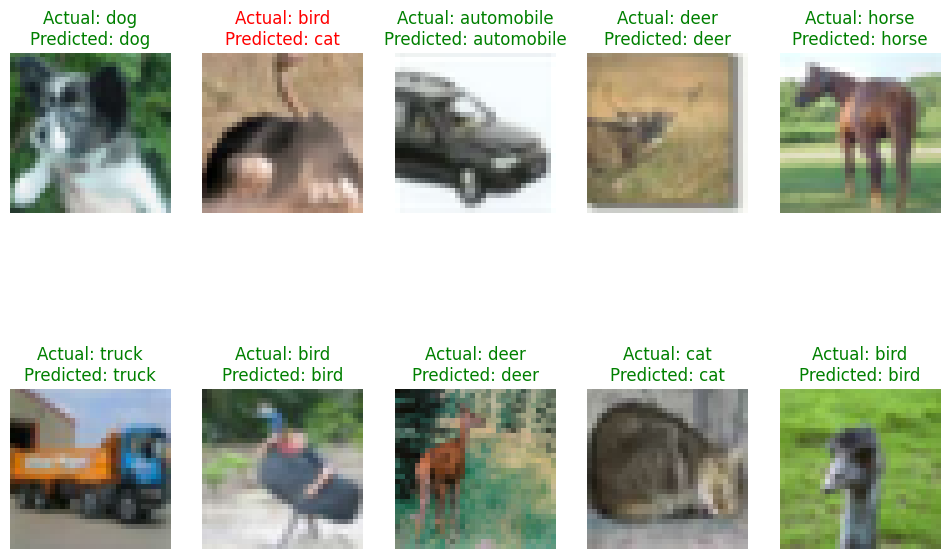

###############################################################################################################################################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Learning rate: 0.010, Loss: 1.72, Training Accuracy: 36.22%, Validation Accuracy: 41.34%, time taken: 13.16s
Epoch 2, Learning rate: 0.010, Loss: 1.39, Training Accuracy: 49.26%, Validation Accuracy: 46.57%, time taken: 13.13s
Epoch 3, Learning rate: 0.009, Loss: 1.26, Training Accuracy: 54.41%, Validation Accuracy: 53.82%, time taken: 13.40s
Epoch 4, Learning rate: 0.009, Loss: 1.16, Training Accuracy: 58.16%, Validation Accuracy: 54.54%, time taken: 13.54s
Epoch 5, Learning rate: 0.008, Loss: 1.05, Training Accuracy: 62.38%, Validation Accuracy: 61.07%, time taken: 16.05s
Epoch 6, Learning rate: 0.008, Loss: 1.00, Training Accuracy: 64.38%, Validation Accuracy: 61.02%, time taken: 13.80s
Epoch 7, Learning rate: 0.007, Loss: 0.91, Training Accuracy: 67.75%, Validation Accuracy: 66.73%, time taken: 14.48s
Epoch 8, Learning rate: 0.007, Loss: 0.85, Training Accuracy: 69.89%, Validation Accuracy: 63.15%, time taken: 14.05s
Epoch 9, Learning rate: 0.007, Loss: 0.80, Training Accu

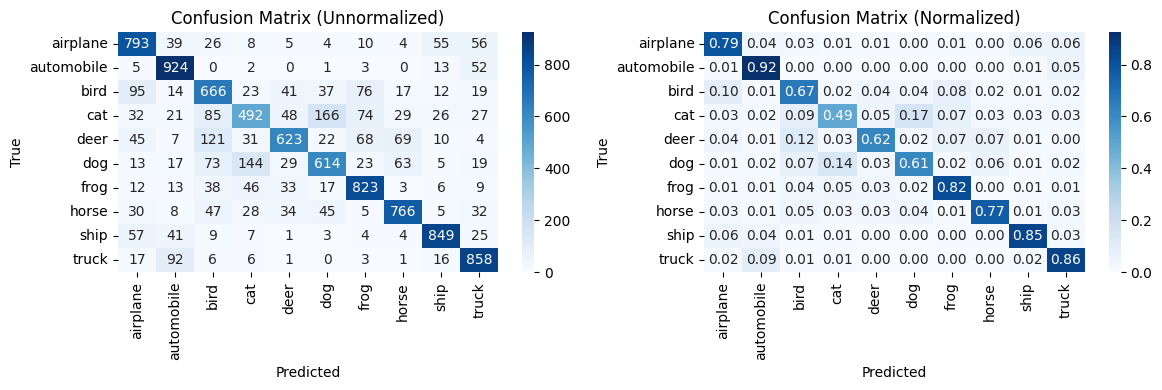


Randomly Select 10 Samples for Testing:


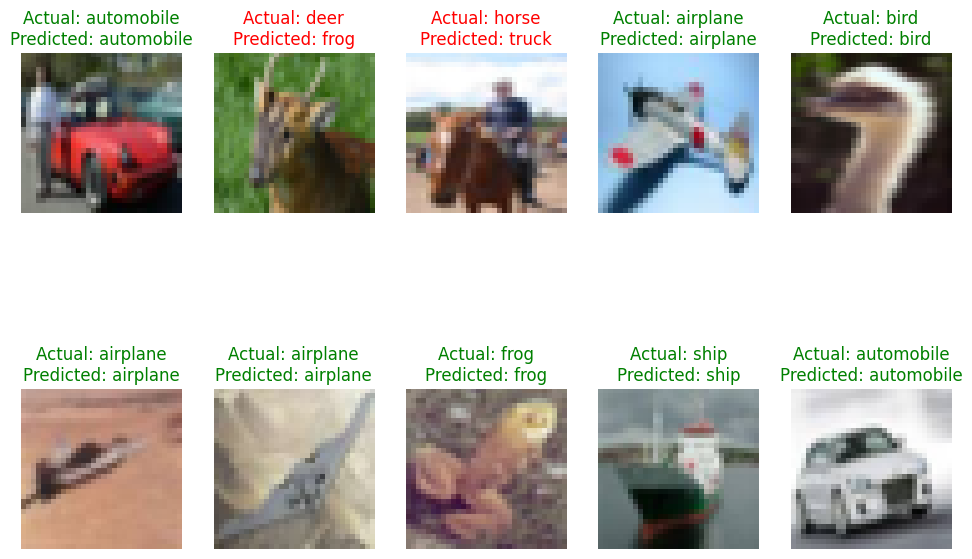

###############################################################################################################################################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Learning rate: 0.010, Loss: 1.70, Training Accuracy: 36.57%, Validation Accuracy: 41.14%, time taken: 13.15s
Epoch 2, Learning rate: 0.010, Loss: 1.42, Training Accuracy: 47.90%, Validation Accuracy: 47.50%, time taken: 13.49s
Epoch 3, Learning rate: 0.009, Loss: 1.28, Training Accuracy: 53.48%, Validation Accuracy: 45.66%, time taken: 13.51s
Epoch 4, Learning rate: 0.009, Loss: 1.17, Training Accuracy: 58.13%, Validation Accuracy: 53.92%, time taken: 13.59s
Epoch 5, Learning rate: 0.008, Loss: 1.08, Training Accuracy: 61.20%, Validation Accuracy: 58.84%, time taken: 13.91s
Epoch 6, Learning rate: 0.008, Loss: 1.01, Training Accuracy: 64.42%, Validation Accuracy: 58.65%, time taken: 13.92s
Epoch 7, Learning rate: 0.007, Loss: 0.91, Training Accuracy: 67.92%, Validation Accuracy: 63.29%, time taken: 14.08s
Epoch 8, Learning rate: 0.007, Loss: 0.86, Training Accuracy: 69.83%, Validation Accuracy: 65.51%, time taken: 14.15s
Epoch 9, Learning rate: 0.007, Loss: 0.80, Training Accu

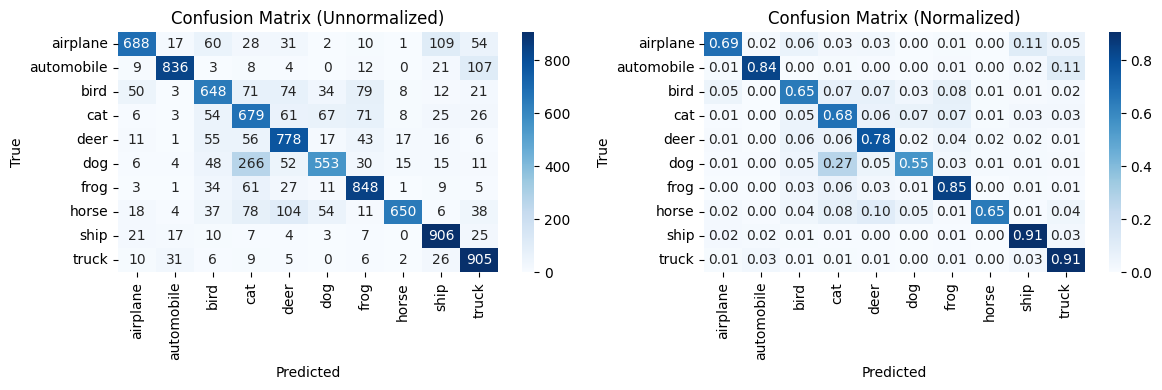


Randomly Select 10 Samples for Testing:


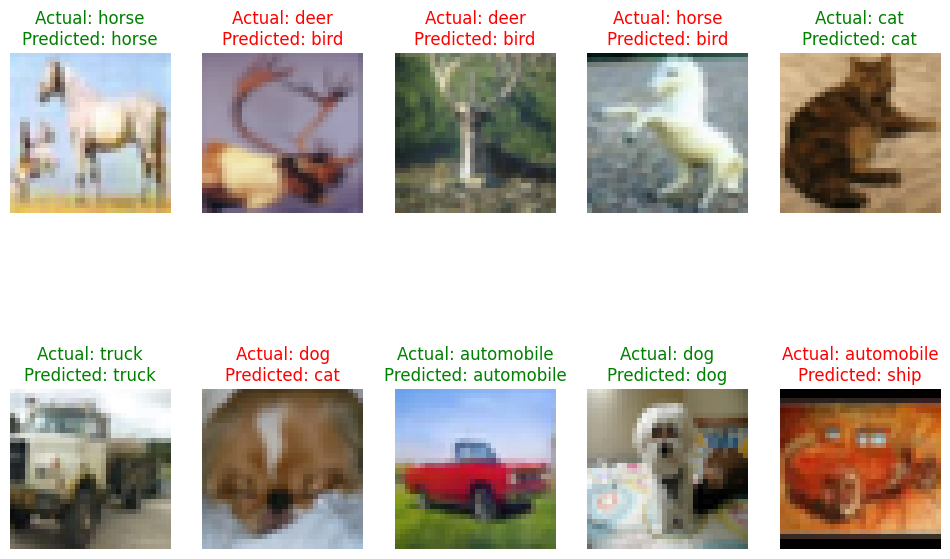

###############################################################################################################################################


In [ ]:
for i in range(num_test):
    combined_train, combined_val, combined_test, combined_loss, combined_time = train_and_test(dataloaders[i][0], dataloaders[i][1], dataloaders[i][2], \
                                                                                       dataloaders[i][3], dataloaders[i][4], dataloaders[i][5], mode="proposed")
    proposed_stat.append((combined_train, combined_val, combined_test, combined_loss, combined_time))
    print("###############################################################################################################################################")

#8. Plot Results:

Compress all the statistics from all three approaches:

In [ ]:
statistics = [norm_stat, progressive_stat, proposed_stat]
train_acc = [[stat[0] for stat in mode] for mode in statistics]
val_acc = [[stat[1] for stat in mode] for mode in statistics]
test_acc = [[stat[2] for stat in mode] for mode in statistics]
train_loss = [[stat[3] for stat in mode] for mode in statistics]
time = [[stat[4] for stat in mode] for mode in statistics]
labels = ["Normal", "Progressive", "Proposed"]
color = ["r", "g", "b"]

Plot the training loss curve at each epoch:

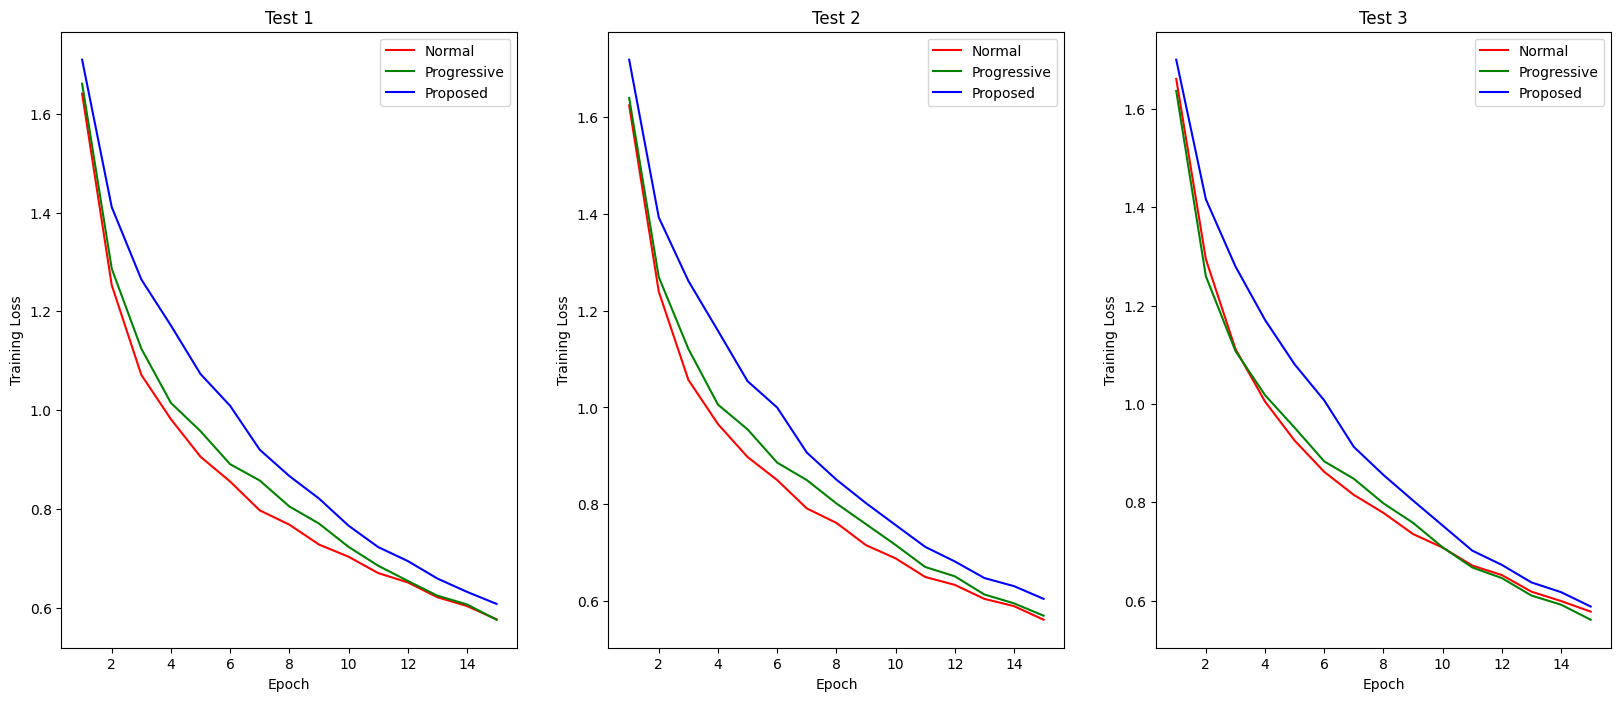

In [ ]:
epoch = range(1, epochs+1)
plt.figure(figsize=(20,8))

for i in range(1, num_test + 1):
    plt.subplot(1, num_test, i)
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    for c, mode in enumerate(train_loss):
      plt.plot(epoch, mode[i-1], color=color[c], label=labels[c])
    plt.legend()
    plt.title(f"Test {i}")

plt.show()

Plot the test accuracy curve at each epoch:

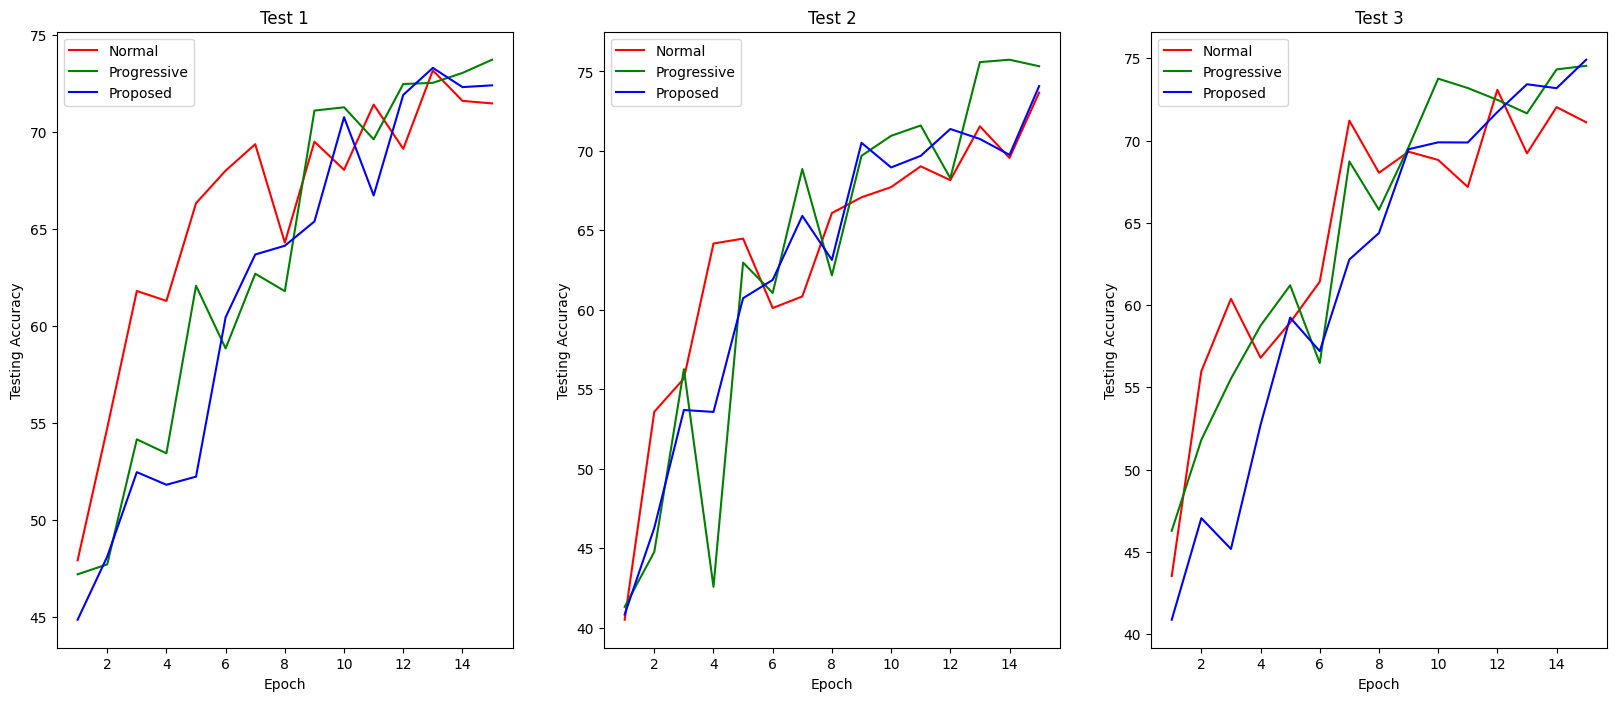

In [ ]:
plt.figure(figsize=(20,8))

for i in range(1, num_test + 1):
    plt.subplot(1, num_test, i)
    plt.xlabel("Epoch")
    plt.ylabel("Testing Accuracy")
    for c, mode in enumerate(test_acc):
      plt.plot(epoch, mode[i-1], color=color[c], label=labels[c])
    plt.legend()
    plt.title(f"Test {i}")

plt.show()

Plot the training and validation accuracy curves at each epoch:

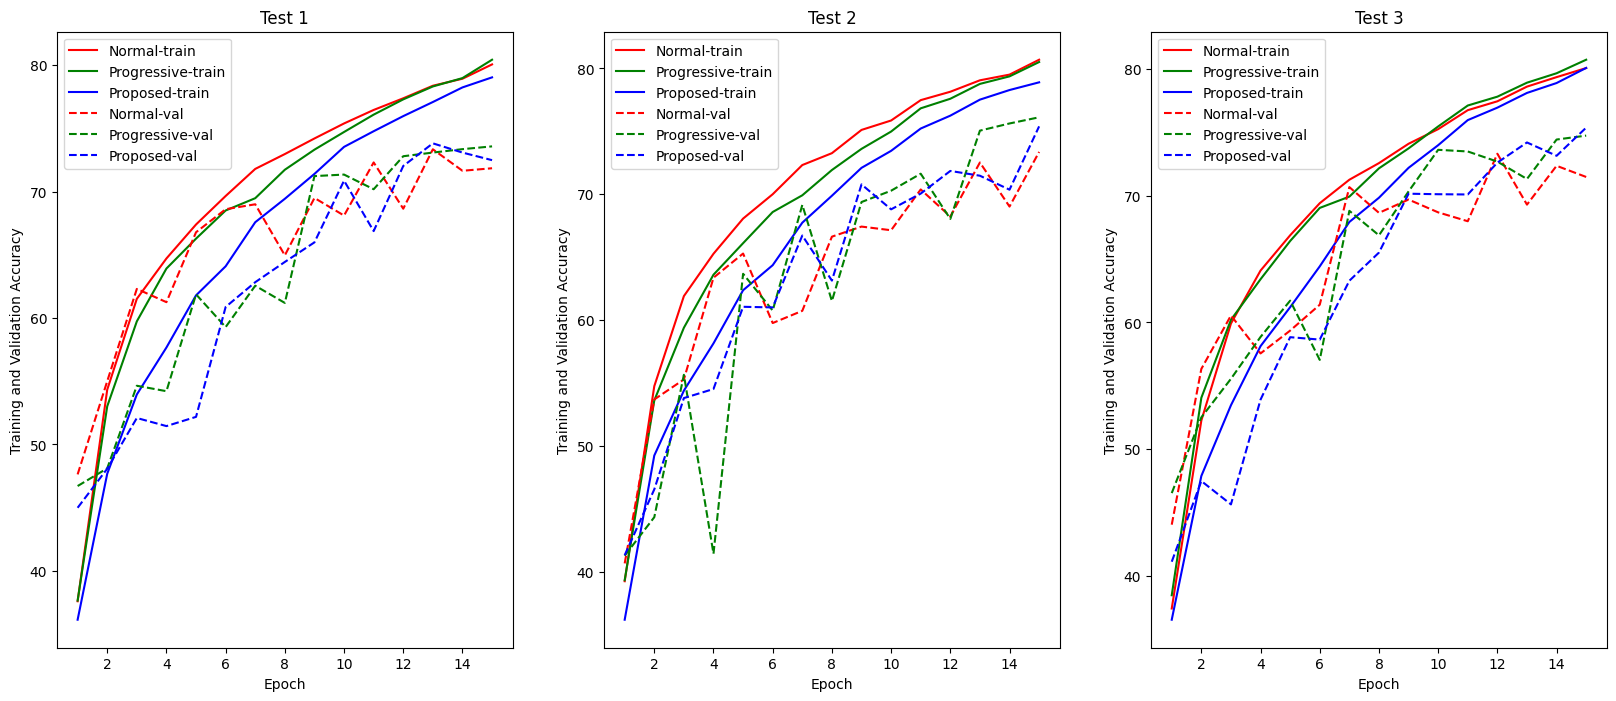

In [ ]:
plt.figure(figsize=(20,8))

for i in range(1, num_test + 1):
    plt.subplot(1, num_test, i)
    plt.xlabel("Epoch")
    plt.ylabel("Training and Validation Accuracy")
    for c, mode in enumerate(train_acc):
      plt.plot(epoch, mode[i-1], color=color[c], label=labels[c]+"-train")
    for c, mode in enumerate(val_acc):
      plt.plot(epoch, mode[i-1], color=color[c], linestyle='dashed', label=labels[c]+"-val")
    plt.legend()
    plt.title(f"Test {i}")

plt.show()

Tabulate the averaged statistics for each training approach:

In [ ]:
# Specify the column names for the table
myTable = PrettyTable(["Approach", "Average Generalization Gap", "Average Test Accuracy", "Average Time Taken (s)"])

avg_test_acc = []
avg_time = []
avg_overfit_deg = []

for mode in test_acc:
    avg = 0
    for test in mode:
        avg += test[len(test) - 1]
    avg /= num_test
    avg_test_acc.append(avg)

for mode in time:
    avg = sum(mode) / num_test
    avg_time.append(avg)

for mode1, mode2 in zip(train_acc, val_acc):
    deg = 0
    for i in range(len(mode1)):
        train = mode1[i]
        val = mode2[i]
        deg += sum(np.abs(np.subtract(train, val))) / epochs
    avg_overfit_deg.append(deg / len(mode1))

for i in range(len(labels)):
    myTable.add_row([labels[i], f"{avg_overfit_deg[i]:.2f}%", f"{avg_test_acc[i]:.2f}%", f"{avg_time[i]:.2f}"])

print(myTable)

+-------------+----------------------------+-----------------------+------------------------+
|   Approach  | Average Generalization Gap | Average Test Accuracy | Average Time Taken (s) |
+-------------+----------------------------+-----------------------+------------------------+
|    Normal   |           5.76%            |         72.08%        |         190.74         |
| Progressive |           5.82%            |         74.53%        |         196.43         |
|   Proposed  |           4.37%            |         73.79%        |         200.41         |
+-------------+----------------------------+-----------------------+------------------------+
